# Project 2 - Term Deposit Marketing

**Goal(s):**

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, in this case to ensure a term deposit subscription. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. 

The firm is looking for ways to improve the success rate for calls made to customers; which is why the objective is to predict if the customer they are calling will subscribe or not (yes/no) to a term deposit (variable y).

Attributes:

- age : age of customer (numeric)
- job : type of job (categorical)
- marital : marital status (categorical)
- education (categorical)
- default: has credit in default? (binary)
- balance: average yearly balance, in euros (numeric)
- housing: has a housing loan? (binary)
- loan: has personal loan? (binary)
- contact: contact communication type (categorical)
- day: last contact day of the month (numeric)
- month: last contact month of year (categorical)
- duration: last contact duration, in seconds (numeric)
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

y - has the client subscribed to a term deposit? (binary)

**Results:**
We were able to obtain a model which predicts if a customer will suscribe or not to a term deposit with 92.76% overall accuracy.
Main features used for this task were : 
- Duration
- Month
- Housing
- Contact_cellular

<!-- # TODO -->
<!-- - We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize. -->

## Analysis

In [1]:
os.chdir('/home/alexandrabinder/Projects/Apziva/')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import *

PROJECT_PATH = os.path.join(os.getcwd(),'P2-Term-Deposit-Marketing')

In [2]:
file_name = 'term-deposit-marketing-2020.csv'
df = pd.read_csv(os.path.join(PROJECT_PATH, file_name))
df = df.rename({'y': 'Y'}, axis=1)

print(f'[DATA SIZE] {df.shape[0]} data with {df.shape[1]-1} attributes\n')

feature_names = df.columns

# display(df.head())

[DATA SIZE] 40000 data with 13 attributes



### Target feature

First lets check if our target variable is balanced or not and if it is imbalanced, for how much. This will allow us to know what measures to take in case of un unbalanced class problem.

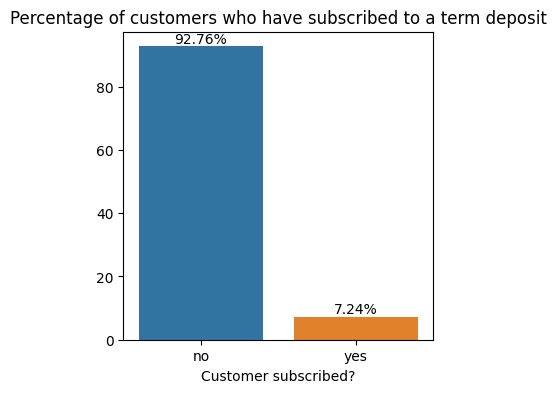

In [3]:
labels = {
    'xlabel': 'Customer subscribed?',
    'title': 'Percentage of customers who have subscribed to a term deposit'
}
plot_barplot_with_percent(df, 'Y', labels)

The target value is unbalanced in a proportion of 12.81% where our class of interest (`yes` class) is lacking data. We will have to treat this problem further on.

In the mean time, let's explore the rest of the data and check for missing values and/or outliers.

### Attributes - Data Wrangling and EDA

In [4]:
true_mask = [True]*df.shape[0]
subscribed_mask = df['Y'] == 'yes'

df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  Y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


No null values are observed in the dataset.

In [5]:
cat_cols, num_cols = [], []
[cat_cols.append(col) if df[col].dtype == 'object' else num_cols.append(col) for col in df.columns[0:-1]];
print(f"{len(num_cols)} numeric attributes {num_cols}\n{len(cat_cols)} categorical attributes {cat_cols}")

5 numeric attributes ['age', 'balance', 'day', 'duration', 'campaign']
8 categorical attributes ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month']


We observe that we have 5 numeric attributes and 8 categorical attributes. Lets analyse them separately.

#### Numeric attributes

In [6]:
df_numeric = df[num_cols]
df_numeric.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


At first glance we get the following information for each of the numerical attributes:
- `age`: minimum and maximum values are between the expected range (population between the ages of 19 and 95). The mean indicates that the population tends to be around 40 years old.
- `balance`: the minimum value is negative; further exploration is in place to analyse if this is a regular situation or not.
- `day`: minimum and maximum values are between the expected range (1 and 31)
- `duration`: the minimum value appears to be 0 seconds; further exploration is in place to quantify how recurrent is this situation
- `campaign`: the maximum values is off bounds with that seen in Q3; further exporation is in place to check if there are any outliers

A quick analysis for each attribute will be made using a graph that combines both a distribution plot and a box plot. For the latter lines will be traced that represent the caps, quartiles, min, max and mean values for each distribution.

##### Age

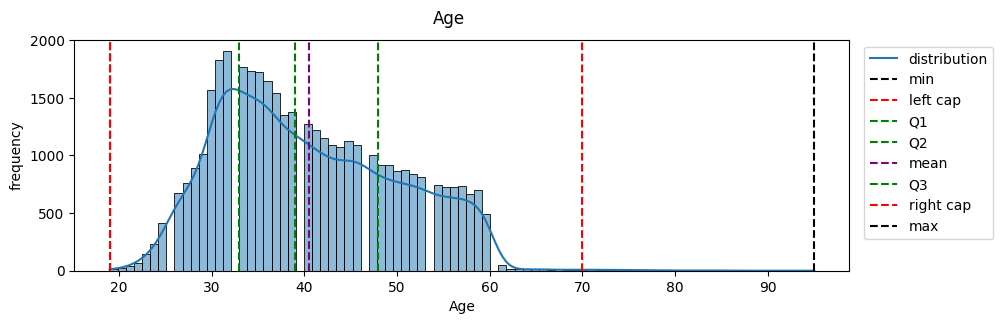

,min,left cap,Q1,Q2,Q3,right cap,max,mean,mode
0,19,19,33.0,39.0,48.0,70,95,40.5446,32


In [7]:
aux = plot_distribution_with_stats(df, 'age')

In [8]:
case_mask = df['age'] > aux.loc[0,'right cap']

print(f'People older than 70 years old appear as outliers, they make up for {get_percent(df, case_mask, df, true_mask)}% of the data')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

People older than 70 years old appear as outliers, they make up for 0.2% of the data
From those people 46.84% (37 entries) subscribed to a term deposit. They represent 0.09% from total.


As mentioned before the minimum and maximum values are between the expected range (population between the ages of 19 and 95). The mean indicates that the population tends to be arround 40 years old. This is confirmed through the graph where they highest frequencies lie around people between 20 and 60 years old.

##### Balance

We had seen before that the balance attribute had negative values. Lets check in how many cases does this happen.

In [9]:
case_mask = df['balance'] < 0

print(f'Negative balance values make up for {get_percent(df, case_mask, df, true_mask)}% of the data')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

case_mask = df['balance'] == 0

print(f'\n$0 balance values make up for {get_percent(df, case_mask, df, true_mask)}% of the data')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

case_mask = df['balance'] > 0

print(f'\nPositive balance values make up for {get_percent(df, case_mask, df, true_mask)}% of the data')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

Negative balance values make up for 9.33% of the data
From those people 5.28% (197 entries) subscribed to a term deposit. They represent 0.49% from total.

$0 balance values make up for 8.02% of the data
From those people 5.58% (179 entries) subscribed to a term deposit. They represent 0.45% from total.

Positive balance values make up for 82.65% of the data
From those people 7.62% (2520 entries) subscribed to a term deposit. They represent 6.3% from total.


We conclude that even though it is more common tu find a positive balance, $0 and negative balances are also possible.

Lets analyse the distribution:

In [10]:
aux = plot_distribution_with_stats(df, 'balance', graph=False)

,min,left cap,Q1,Q2,Q3,right cap,max,mean,mode
0,-8019,-1818,54.0,407.0,1319.0,3216,102127,1274.27755,0


Results show that there are outliers on both lower and upper bounds; lets quantify how many on each side and then plot the distribution graph eliminating the outliers to get a closer look at the distribution:

0.06% (24 entries) of the data are lower bound outliers
From these cases 8.33% (2 entries) subscribed to a term deposit. They represent 0.0% from total.

10.65% (4259 entries) of the data are upper bound outliers
From these cases 10.07% (429 entries) subscribed to a term deposit. They represent 1.07% from total.


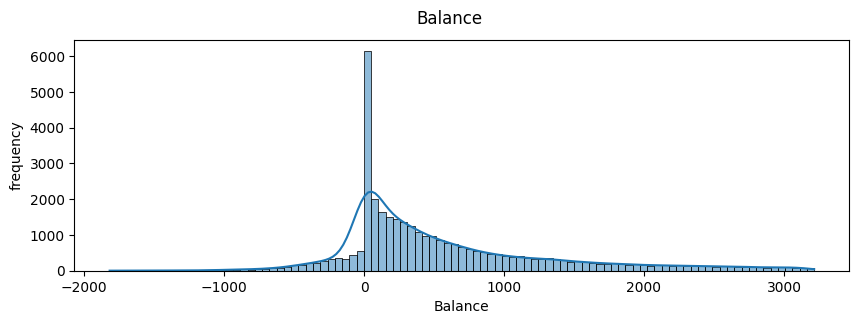

In [11]:
case_mask = df['balance'] <= aux.loc[0, 'left cap']

print(f'{get_percent(df, case_mask, df, true_mask)}% ({df[case_mask].shape[0]} entries) of the data are lower bound outliers')
print(f'From these cases {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

case_mask = df['balance'] >= aux.loc[0, 'right cap']

print(f'\n{get_percent(df, case_mask, df, true_mask)}% ({df[case_mask].shape[0]} entries) of the data are upper bound outliers')
print(f'From these cases {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

mask = (df['balance'] >= aux.loc[0, 'left cap']) & (df['balance'] <= aux.loc[0, 'right cap'])
plot_distribution_with_stats(df[mask], 'balance', lines=False);

It draws to our attention the peak in frequency near the $0 balance. Taking into account that the bins have a size of 50, this sample of clients have balances between $0-$50.

In summary, balance values are behaving as expected.

##### Day

PEOPLE WHO HAVE SUBSCRIBED TO A TERM DEPOSIT:


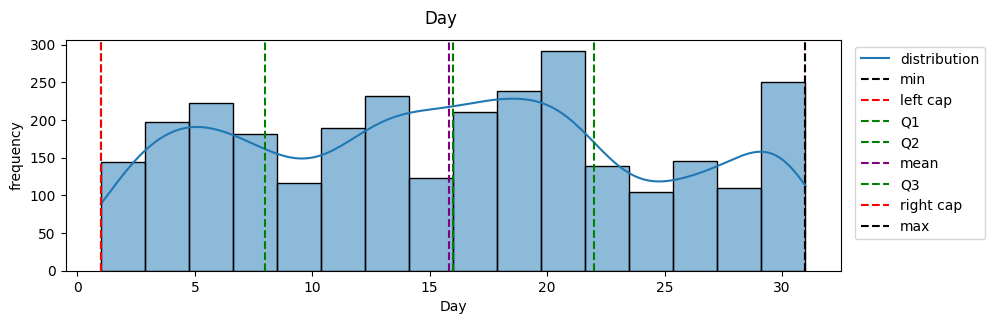

,min,left cap,Q1,Q2,Q3,right cap,max,mean,mode
0,1,1,8.0,16.0,22.0,31,31,15.827003,30


PEOPLE WHO HAVE NOT SUBSCRIBED TO A TERM DEPOSIT:


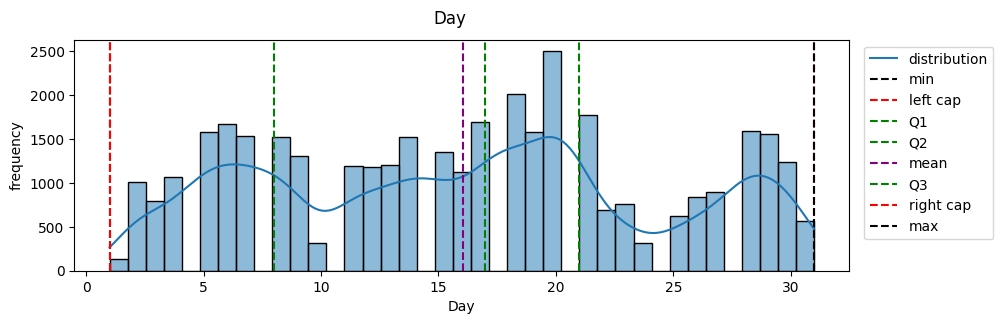

,min,left cap,Q1,Q2,Q3,right cap,max,mean,mode
0,1,1,8.0,17.0,21.0,31,31,16.032072,20


In [12]:
print('PEOPLE WHO HAVE SUBSCRIBED TO A TERM DEPOSIT:')
plot_distribution_with_stats(df[subscribed_mask], 'day');

print('PEOPLE WHO HAVE NOT SUBSCRIBED TO A TERM DEPOSIT:')
plot_distribution_with_stats(df[~subscribed_mask], 'day');

For better appreciation of the two cases (subscribed and unsubscribed customers), two graphs were presented.

No particular pattern is observed for both cases.

##### Duration

We had seen before that the duration attribute had 0 values. Lets check in how many cases does this happen.

In [13]:
case_mask = df['duration'] == 0

print(f'0 seconds duration entries make up for {get_percent(df, case_mask, df, true_mask)}% of the data ({df[case_mask].shape[0]} entries)')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

0 seconds duration entries make up for 0.01% of the data (3 entries)
From those people 0.0% (0 entries) subscribed to a term deposit. They represent 0.0% from total.


Since there are only 3 entries that have contacts of 0 seconds of duration, we decided to leave them as they are. Lets plot the distribution:

In [14]:
aux = plot_distribution_with_stats(df, 'duration', graph=False);

,min,left cap,Q1,Q2,Q3,right cap,max,mean,mode
0,0,0,100.0,175.0,313.0,632,4918,254.8243,124


In [15]:
print(f"Maximum contact duration was of {np.round(aux.loc[0, 'max']/60/60, 2)} hs")
print(f"Mean contact duration was of {np.round(aux.loc[0, 'mean']/60, 2)} min")
print(f"Mode contact duration was of {np.round(aux.loc[0, 'mode']/60, 2)} min")

Maximum contact duration was of 1.37 hs
Mean contact duration was of 4.25 min
Mode contact duration was of 2.07 min


Results show that the maximum contact duration was of aproximately 1.5 hours, even though this is a possible scenario, it belongs to the outliers of the distribuition; in other words, it belongs to exceptional cases. The mean contact duration is of about 4 minutes and in general, most calls have a duration of about 2 minutes.

The rest of the statistical information shows that there are upper bounds outliers; lets quantify how many and then plot the distribution graph eliminating the outliers to get a closer look at the distribution:

7.53% (3012 entries) of the data are upper bound outliers
From these cases 47.88% (1442 entries) subscribed to a term deposit. They represent 3.6% from total.


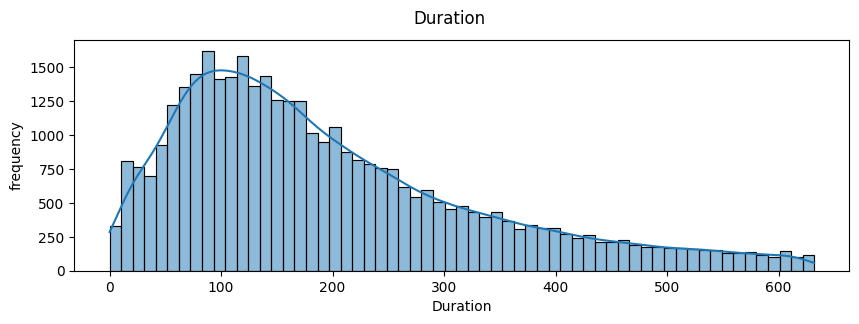

In [16]:
case_mask = df['duration'] >= aux.loc[0, 'right cap']

print(f'{get_percent(df, case_mask, df, true_mask)}% ({df[case_mask].shape[0]} entries) of the data are upper bound outliers')
print(f'From these cases {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

mask = (df['duration'] >= aux.loc[0, 'left cap']) & (df['duration'] <= aux.loc[0, 'right cap'])
plot_distribution_with_stats(df[mask], 'duration', lines=False);

Contact duration values are behaving as expected. A right / positive skewed distribution is observed with mean at 254 seconds.

##### Campaign

In [17]:
print('Campaign attribute values:')
print(df['campaign'].unique())
aux = plot_distribution_with_stats(df, 'campaign', graph=False);

Campaign attribute values:
[ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32 18 22 15 17 25 21
 43 51 63 41 26 28 55 50 38 23 20 29 31 37 30 46 27 58 33 35 34 36 39 44]


,min,left cap,Q1,Q2,Q3,right cap,max,mean,mode
0,1,1,1.0,2.0,3.0,6,63,2.882175,1


The campaign attribute has discrete values ranging from 1 to 63. We observe that the maximum value is further away from that of Q3 which indicates that upper bounds outliers are present. lets quantify how many and then plot the distribution graph eliminating the outliers to get a closer look at the distribution:

10.55% (4220 entries) of the data are upper bound outliers
From these cases 4.81% (203 entries) subscribed to a term deposit. They represent 0.51% from total.


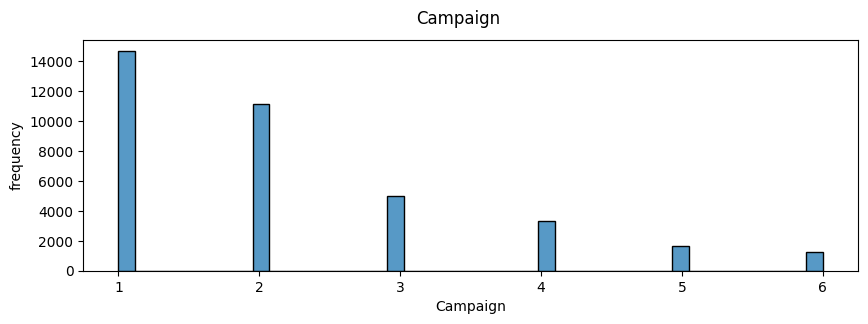

In [18]:
case_mask = df['campaign'] >= aux.loc[0, 'right cap']

print(f'{get_percent(df, case_mask, df, true_mask)}% ({df[case_mask].shape[0]} entries) of the data are upper bound outliers')
print(f'From these cases {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

mask = (df['campaign'] >= aux.loc[0, 'left cap']) & (df['campaign'] <= aux.loc[0, 'right cap'])
plot_distribution_with_stats(df[mask], 'campaign', lines=False, kde=False);

In [19]:
case_mask = mask

print(f'{get_percent(df, case_mask, df, true_mask)}% ({df[case_mask].shape[0]} entries) of the data have had between 1 and 6 contacts during this campaign')
print(f'From these cases {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

92.52% (37008 entries) of the data have had between 1 and 6 contacts during this campaign
From these cases 7.46% (2761 entries) subscribed to a term deposit. They represent 6.9% from total.


Contact duration values are behaving as expected. A right / positive skewed distribution is observed with mean between 2 and 3 contacts during the campaign.

#### Categorical attributes

According to the data description we can identify real categorical attributes and binary attributes:
- `categorical`: job, marital, education, contact, month
- `binary`: default, housing, loan

Lets start with the binary attributes:

##### Binary attributes

In [20]:
for col in ['default', 'housing', 'loan']: print(col, df[col].unique())

default ['no' 'yes']
housing ['yes' 'no']
loan ['no' 'yes']


We observe that we can easily start off by replacing 'no' values for 0 and 'yes' values for 1.

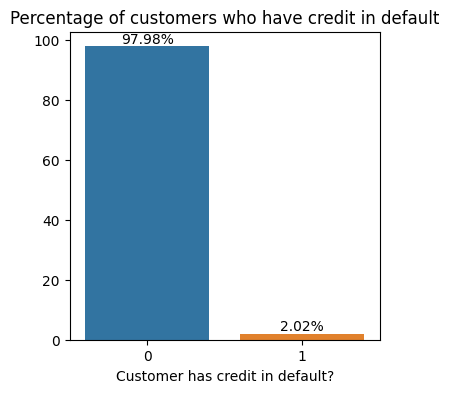

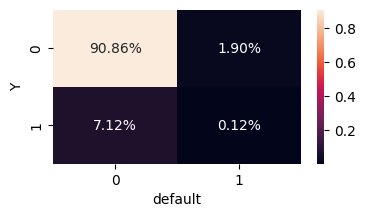

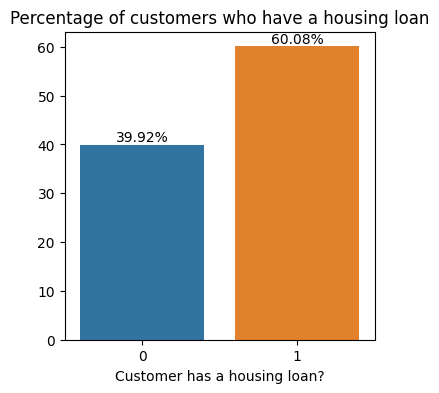

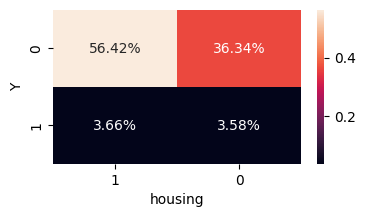

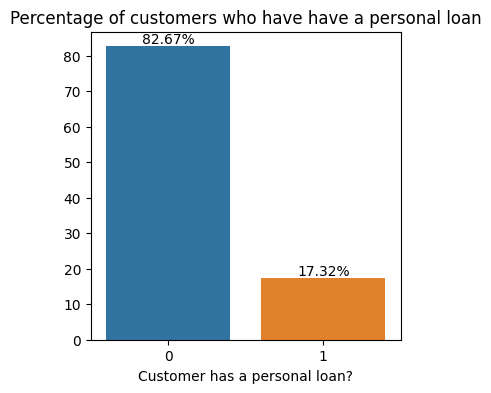

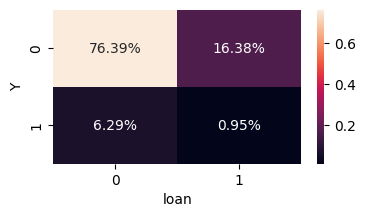

In [21]:
df[['default', 'housing', 'loan']] = df[['default', 'housing', 'loan']].replace({'no': 0, 'yes': 1})

labels = {
    'default': {
        'xlabel': 'Customer has credit in default?',
        'title': 'Percentage of customers who have credit in default'
    },
    'housing': {
        'xlabel': 'Customer has a housing loan?',
        'title': 'Percentage of customers who have a housing loan'
    },
    'loan': {
        'xlabel': 'Customer has a personal loan?',
        'title': 'Percentage of customers who have have a personal loan'
    }
}

for col in ['default', 'housing', 'loan']:
    plot_barplot_with_percent(df, col, labels[col])
    plot_heatmap_with_target_dist(df, col, figsize=(4,2))

We can observe that some attributes appear to have more correlation with purchasing a term deposit:
People which don't have credit in default and that haven't got a personal loan tend to purchase term deposits.

##### Real categorical attributes

**Job**

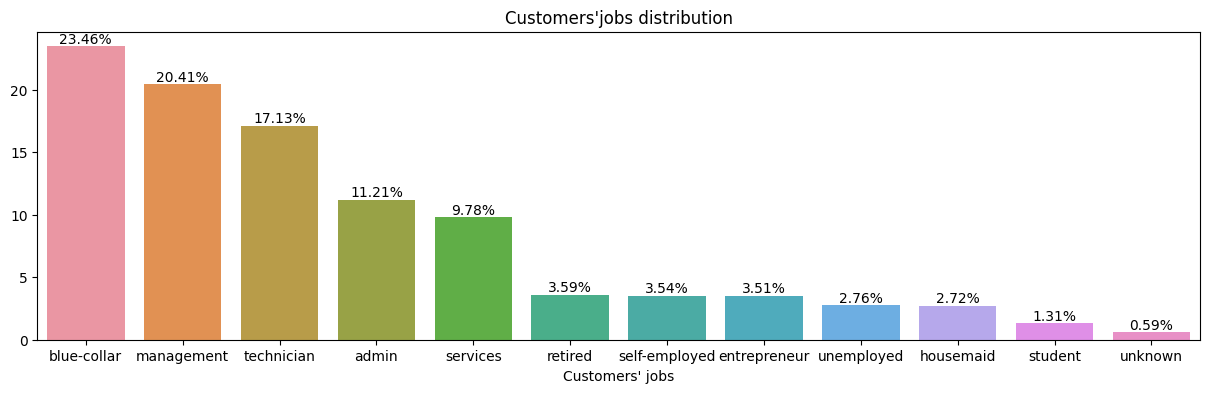

In [22]:
labels = {
        'xlabel': "Customers' jobs",
        'title': "Customers'jobs distribution"
}
plot_barplot_with_percent(df, 'job', labels, figsize=(15,4))

The `unkown` class represents 0.59% of data. Lets check if there are entries that belong to this class which have subscribed to a term deposit or not. If the latter, then these entries can be deleted since we have an unbalanced problem and they don't help weigh out the minority class.

In [23]:
case_mask = df['job'] == 'unknown'

print(f'Entries with `unkown` jobs make up for {get_percent(df, case_mask, df, true_mask)}% of the data ({df[case_mask].shape[0]} entries)')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

Entries with `unkown` jobs make up for 0.59% of the data (235 entries)
From those people 7.23% (17 entries) subscribed to a term deposit. They represent 0.04% from total.


Since 7 out of 12 classes represent less than 5% of the data, classes can be re-grouped into looser groups, always taking into account combine or unify classes with similar behaviour when talking about term deposit subscriptions. The following classes were re-grouped:
- `unemployed`: unemployed + student + unknown
- `self-employed`: self-employed + entrepreneur

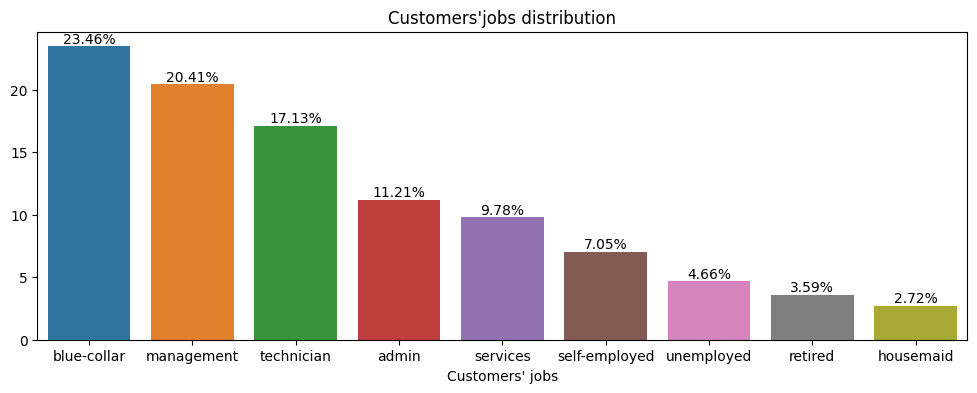

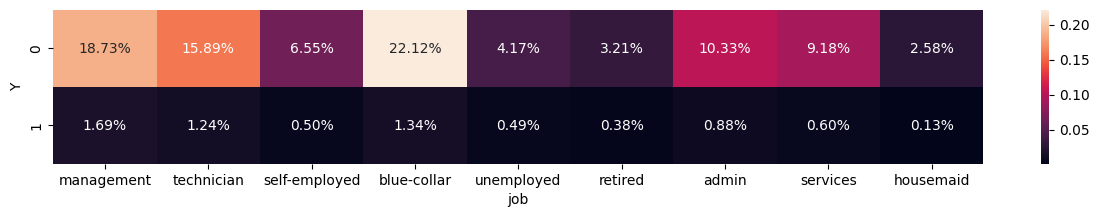

In [24]:
df['job'] = df['job'].replace({
                'student': 'unemployed',
                'unknown': 'unemployed',
                'entrepreneur': 'self-employed'
            })

plot_barplot_with_percent(df, 'job', labels, figsize=(12,4))
plot_heatmap_with_target_dist(df, 'job', figsize=(15,2))

People who have a blue-collar job, work as technicians or in management appear to buy more term deposits than those who don't.

**Marital status**

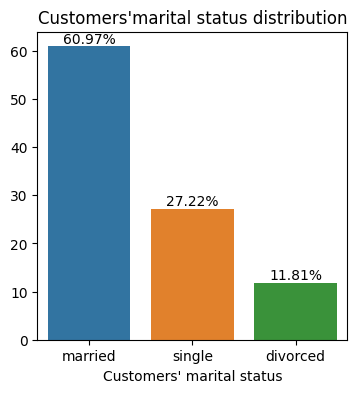

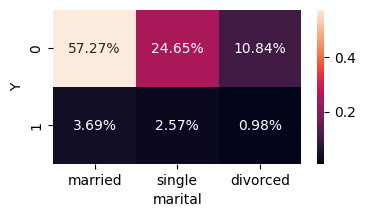

In [25]:
labels = {
        'xlabel': "Customers' marital status",
        'title': "Customers'marital status distribution"
}
plot_barplot_with_percent(df, 'marital', labels)
plot_heatmap_with_target_dist(df, 'marital', figsize=(4,2))

Both married and single people tend to buy more term deposits than divorcees. Married people tend to have more purchases than single people.

**Education**

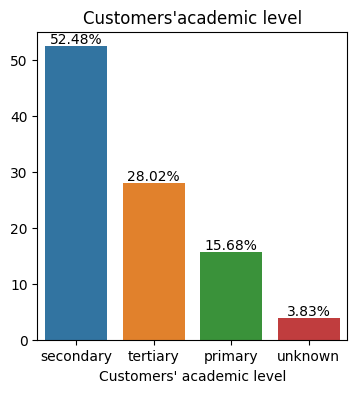

In [26]:
labels = {
        'xlabel': "Customers' academic level",
        'title': "Customers'academic level"
}
plot_barplot_with_percent(df, 'education', labels)

The `unkown` class represents 3.83% of data. Lets check if there are entries that belong to this class which have subscribed to a term deposit or not. If the latter, then these entries can be deleted since we have an unbalanced problem and they don't help weigh out the minority class.

In [27]:
case_mask = df['education'] == 'unknown'

print(f'Entries with `unkown` education make up for {get_percent(df, case_mask, df, true_mask)}% of the data ({df[case_mask].shape[0]} entries)')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

Entries with `unkown` education make up for 3.83% of the data (1531 entries)
From those people 6.27% (96 entries) subscribed to a term deposit. They represent 0.24% from total.


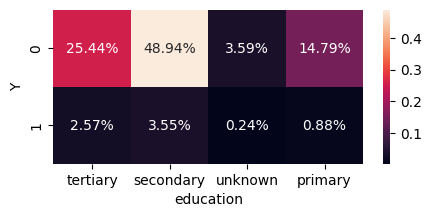

In [28]:
plot_heatmap_with_target_dist(df, 'education', figsize=(5,2))

Interestingly, people with a secondary education tend to buy more term deposits than the rest of the possibilities, even those with a tertiary education.

**Contact communication type**

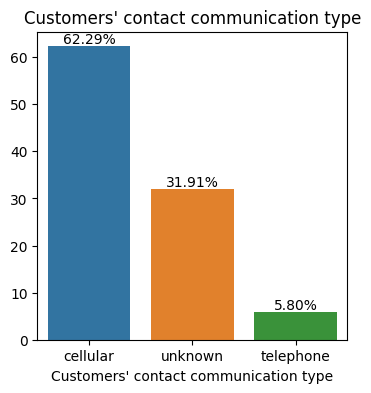

In [29]:
labels = {
        'xlabel': "Customers' contact communication type",
        'title': "Customers' contact communication type"
}
plot_barplot_with_percent(df, 'contact', labels)

The `unkown` class represents 31.91% of data. Lets check if there are entries that belong to this class which have subscribed to a term deposit or not. If the latter, then these entries can be deleted since we have an unbalanced problem and they don't help weigh out the minority class.

In [30]:
case_mask = df['contact'] == 'unknown'

print(f'Entries with `unkown` contact communication type make up for {get_percent(df, case_mask, df, true_mask)}% of the data ({df[case_mask].shape[0]} entries)')
print(f'From those people {get_percent(df, case_mask & subscribed_mask, df, case_mask)}% ({df[case_mask & subscribed_mask].shape[0]} entries) subscribed to a term deposit. They represent {get_percent(df, case_mask & subscribed_mask, df, true_mask)}% from total.')

Entries with `unkown` contact communication type make up for 31.91% of the data (12765 entries)
From those people 3.89% (497 entries) subscribed to a term deposit. They represent 1.24% from total.


Since nearly 32% of the entries belong to the `unkown` class, they will not be remove at this instance. Instead, they will be taken into account in case the models have a poor performance.

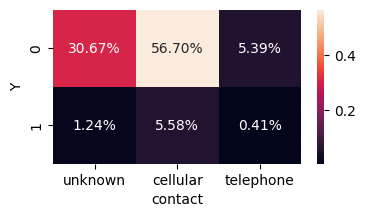

In [31]:
plot_heatmap_with_target_dist(df, 'contact', figsize=(4,2))

The trend shows that contacts made by cellphones are more effective than those made by telephone.

**Month**

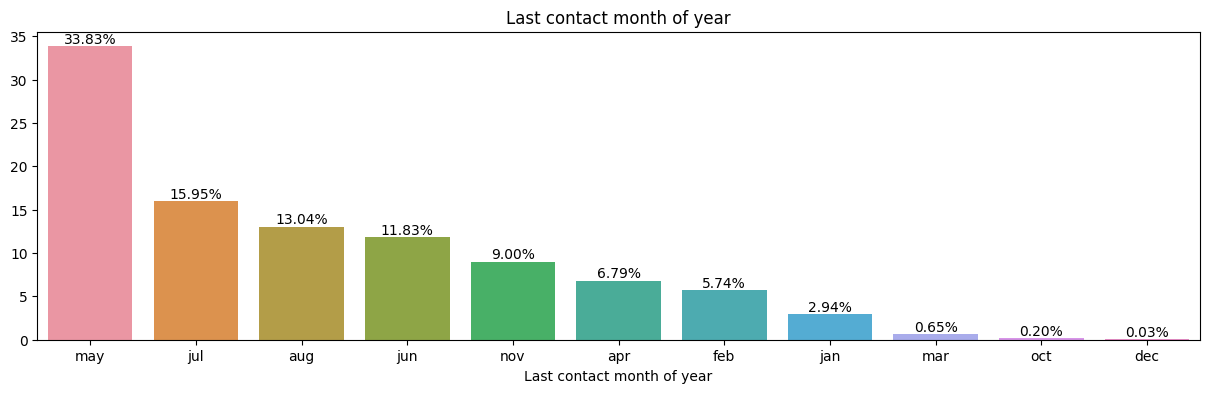

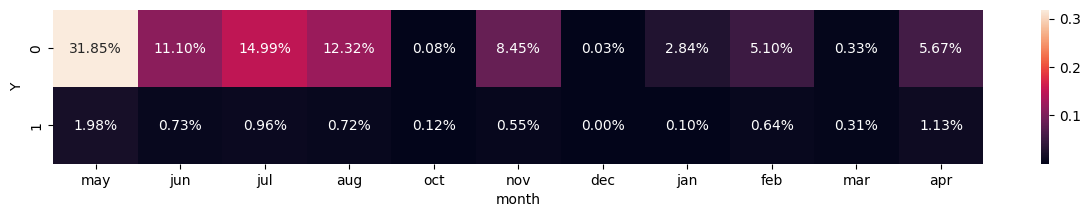

In [32]:
labels = {
        'xlabel': "Last contact month of year",
        'title': "Last contact month of year"
}
plot_barplot_with_percent(df, 'month', labels, figsize=(15,4))
plot_heatmap_with_target_dist(df, 'month', figsize=(15,2))

#### Further EDA Analysis for numerical attributes

Lets graph two pairplots too see numerical attribute's behaviour for both `'Y' == 'yes'` and `'Y' == 'no'`

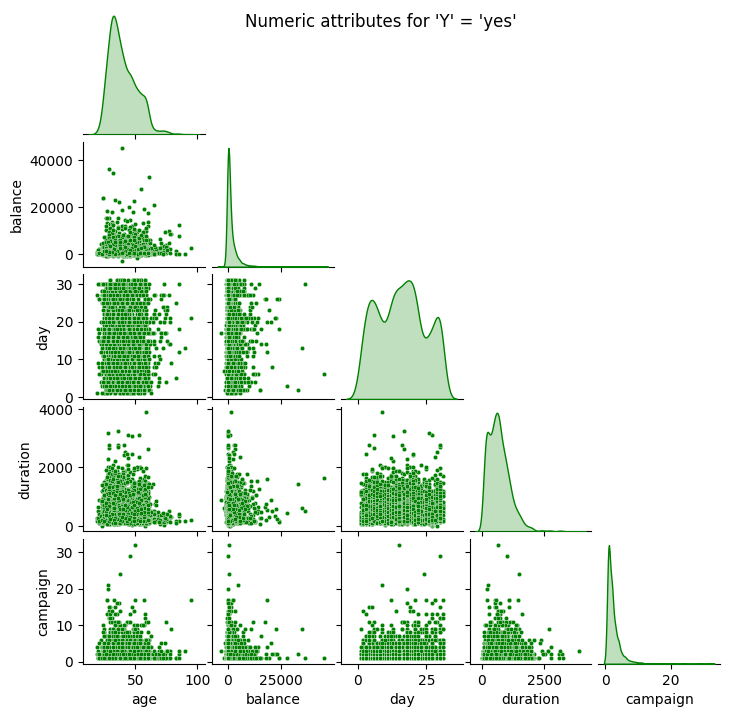

In [33]:
ax = sns.pairplot(df.loc[df['Y'] == 'yes', num_cols], diag_kind='kde', corner=True, plot_kws={'s': 10, 'color': 'green'}, diag_kws={'color': 'green'});
ax.fig.set_size_inches(7,7)
ax.fig.suptitle("Numeric attributes for 'Y' = 'yes'");

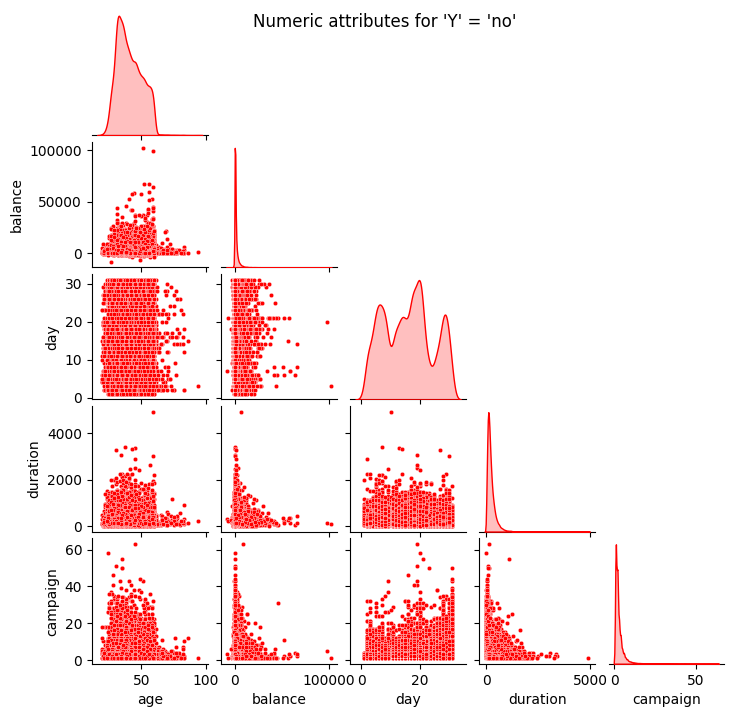

In [34]:
ax = sns.pairplot(df.loc[df['Y'] == 'no', num_cols], diag_kind='kde', corner=True, plot_kws={'s': 10, 'color': 'red'}, diag_kws={'color': 'red'});
ax.fig.set_size_inches(7,7)
ax.fig.suptitle("Numeric attributes for 'Y' = 'no'");

Both pairplots show similar behaviours.

CHI SQUARE TEST BETWEEN CATEGORICAL ATTRIBUTES
If feature combination is not printed, features are NOT correlated.

--> Target vs features
[Y-job] p-value: 0.0 --> result IS significant. Features are correlated.
[Y-marital] p-value: 0.0 --> result IS significant. Features are correlated.
[Y-education] p-value: 0.0 --> result IS significant. Features are correlated.
[Y-contact] p-value: 0.0 --> result IS significant. Features are correlated.
[Y-month] p-value: 0.0 --> result IS significant. Features are correlated.

--> Between features
[marital-education] p-value: 0.0 --> result IS significant. Features are correlated.
[marital-contact] p-value: 0.0 --> result IS significant. Features are correlated.
[marital-month] p-value: 0.0 --> result IS significant. Features are correlated.
[education-contact] p-value: 0.0 --> result IS significant. Features are correlated.
[education-month] p-value: 0.0 --> result IS significant. Features are correlated.
[contact-month] p-value: 0.0 --> result I

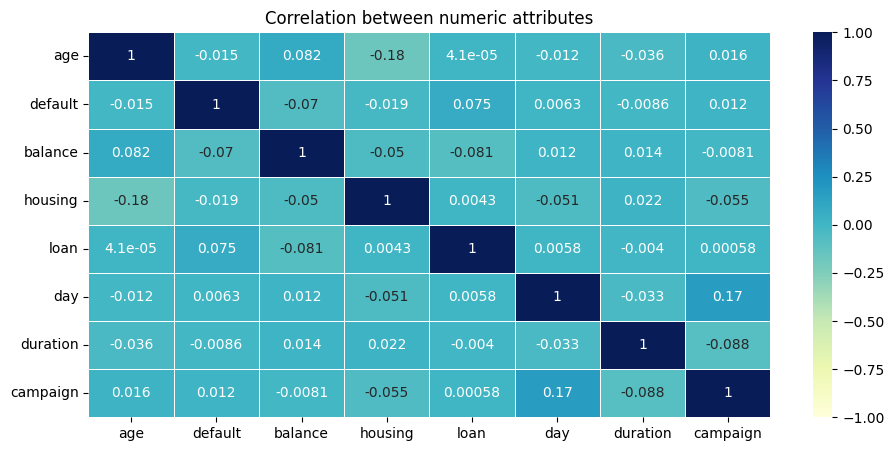

In [35]:
stat_analysis(df, 'Y')

## Models

### Dummy variables and oversampling

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import tree
from IPython.display import Image

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc


In [37]:
# Transform categorical cariables in onehotencoding
num_cols, cat_cols = get_num_cat_columns(df)
X = one_hot_encode(df, 'Y', cat_cols)

In [38]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(X, df, 'Y', test_size=0.2, val_size=0.2, partitions=3)
print('\ny_train composition:')
print(y_train.value_counts())

X_train (25600, 33) 	X_val (6400, 33) 	X_test (8000, 33)
y_train (25600,) 	y_val (6400,) 		y_test (8000,)

y_train composition:
no     23745
yes     1855
Name: Y, dtype: int64


In [39]:
# Oversample minority class
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_train_oversamp, y_train_oversamp = oversampler.fit_resample(X_train, y_train)
print('X_train shape\t', X_train_oversamp.shape)
print('y_train shape\t', y_train_oversamp.shape)

print('\ny_train_oversamp composition:')
print(y_train_oversamp.value_counts())

X_train shape	 (47490, 33)
y_train shape	 (47490,)

y_train_oversamp composition:
no     23745
yes    23745
Name: Y, dtype: int64


### Models overview

We start by testing different classification models to get a first selection. These will not be tunned at this instance.

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, confusion_matrix

In [41]:
# We generate a dataframe to keep record of the different model performances
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Report'])

results.loc[results.shape[0], :] = test_multiple_models(KNeighborsClassifier(), 'KNeighboursClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val)
results.loc[results.shape[0], :] = test_multiple_models(RandomForestClassifier(random_state=42), 'RandomForestClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val)
results.loc[results.shape[0], :] = test_multiple_models(GradientBoostingClassifier(random_state=42), 'GradientBoostingClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val)
# results.loc[results.shape[0], :] = test_multiple_models(XGBClassifier(random_state=42), 'XGBClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val)
results.loc[results.shape[0], :] = test_multiple_models(AdaBoostClassifier(random_state=42), 'AdaBoostClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val)
results.loc[results.shape[0], :] = test_multiple_models(LGBMClassifier(random_state=42), 'LGBMClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val)

results.loc[:, ['Model', 'Accuracy', 'Precision']].sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision
1,RandomForestClassifier,0.931094,0.528767
4,LGBMClassifier,0.887656,0.381567
2,GradientBoostingClassifier,0.867188,0.34202
3,AdaBoostClassifier,0.859688,0.323339
0,KNeighboursClassifier,0.858594,0.273286


We observe that the top 3 models who got a better starting accuracy metric were the Random Forest Classifier, the LGBM Classifier and the Gradient Boosting Classifier. Next we will tune these models by applying a grid search and analysing their feature importance.

### Selected models

In [42]:
# We generate a dataframe to keep record of the different model performances
results = pd.DataFrame(columns=['Model', 'Train acc', 'Val acc', 'Train report', 'Val report'])

#### Gradient Boosting Classifier

In [43]:
model = GradientBoostingClassifier(random_state=42)

parameter_space = {"n_estimators": [50, 75, 100],      # Number of boosted trees to fit.
                    "max_depth": [1, 2, 3],            # Maximum tree depth for base learners.
                    "learning_rate": [0.0001, 0.001],      # learning rate (xgb’s “eta”)
                    "min_samples_split": [10, 15],
                    "min_samples_leaf": [5, 10]
}

trained_model = model_CV_grid_search(model, parameter_space, X_train_oversamp, y_train_oversamp, best_set=True)
best_model = trained_model
results.loc[results.shape[0], :] = evaluate_model(trained_model, 'GradientBoostingClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val)

Best set of parameters: 
  {'learning_rate': 0.001, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}

CV best accuracy: 83.98%

Training accuracy = 84.02%
Testing accuracy = 85.7%


We can see that the best set of parameters is:
- `learning_rate`: 0.001
- `max_depth`: 3
- `min_samples_leaf`: 5
- `min_samples_split`: 10
- `n_estimators`: 100

Comparing training and testing accuracy (1.68% difference) we can conclude that the model is not overfitting. Next we analysed the feature importance to see if there is any room for further improvement.


In [44]:
# FEATURE IMPORTANCE
f_impo = pd.DataFrame({"Feature": X_train_oversamp.columns, 
              "Importance": trained_model.best_estimator_.feature_importances_}).sort_values(by="Importance", ascending=False)
f_impo

,Feature,Importance
6,duration,0.799196
31,month_mar,0.079692
32,month_apr,0.077157
3,housing,0.034921
21,contact_cellular,0.009035
25,month_aug,0.000000
20,education_primary,0.000000
22,contact_telephone,0.000000
23,month_jun,0.000000
24,month_jul,0.000000


In [45]:
col1 = f_impo.loc[f_impo['Importance'] > 0, 'Feature'].values

In [46]:
print('USING ALL FEATURES')
evaluate_model(best_model, 'GradientBoostingClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val)

print('\nELIMINATING FEATURES WITH IMPORTANCE = 0')
trained_model = model_CV_grid_search(model, parameter_space, X_train_oversamp, y_train_oversamp, cols=col1)
results.loc[results.shape[0], :] = evaluate_model(trained_model, 'GradientBoostingClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val, cols=col1)

USING ALL FEATURES
Training accuracy = 84.02%
Testing accuracy = 85.7%

ELIMINATING FEATURES WITH IMPORTANCE = 0
Training accuracy = 84.02%
Testing accuracy = 85.7%


Feature importance analysis shows that all features with importance = 0 can be eliminated since the same result is obtained with or without them. In this case we would keep the following attributes: duration, month_mar, month_apr, housing, contact_cellular.


#### LGBM Classifier

In [47]:
model = LGBMClassifier(random_state=42)

parameter_space = {"n_estimators": [25, 50, 100],      # Number of boosted trees to fit.
                    "max_depth": [1, 2, 3],            # Maximum tree depth for base learners.
                    "learning_rate": [0.0001, 0.001],      # Boosting learning rate (xgb’s “eta”)
                    "boosting_type": ['gbdt']
}

trained_model = model_CV_grid_search(model, parameter_space, X_train_oversamp, y_train_oversamp, best_set=True)
best_model = trained_model
results.loc[results.shape[0], :] = evaluate_model(trained_model, 'LGBMClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val)

Best set of parameters: 
  {'boosting_type': 'gbdt', 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 100}

CV best accuracy: 83.98%

Training accuracy = 83.94%
Testing accuracy = 85.75%


We can see that the best set of parameters is:
- `boosting_type`: 'gbdt'
- `learning_rate`: 0.001
- `max_depth`: 3
- `n_estimators`: 100

Comparing training and testing accuracy (1.81% difference) we can conclude that the model is not overfitting. Next we analysed the feature importance to see if there is any room for further improvement.

In [48]:
# FEATURE IMPORTANCE
f_impo = pd.DataFrame({"Feature": X_train_oversamp.columns, 
              "Importance": trained_model.best_estimator_.feature_importances_}).sort_values(by="Importance", ascending=False)
f_impo

,Feature,Importance
6,duration,300
32,month_apr,100
31,month_mar,100
3,housing,100
21,contact_cellular,100
25,month_aug,0
20,education_primary,0
22,contact_telephone,0
23,month_jun,0
24,month_jul,0


In [49]:
col1 = f_impo.loc[f_impo['Importance'] > 0, 'Feature'].values

In [50]:
print('USING ALL FEATURES')
evaluate_model(best_model, 'LGBMClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val)

print('\nELIMINATING FEATURES WITH IMPORTANCE = 0')
trained_model = model_CV_grid_search(model, parameter_space, X_train_oversamp, y_train_oversamp, cols=col1)
results.loc[results.shape[0], :] = evaluate_model(trained_model, 'LGBMClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val, cols=col1);

USING ALL FEATURES
Training accuracy = 83.94%
Testing accuracy = 85.75%

ELIMINATING FEATURES WITH IMPORTANCE = 0
Training accuracy = 83.94%
Testing accuracy = 85.75%


Feature importance analysis shows that all features with importance = 0 can be eliminated since the same result is obtained with or without them. In this case we would keep the following features: duration, month_apr, month_mar, housing, contact_cellular.

#### Random Forest Classifier

In [51]:
model = RandomForestClassifier(random_state=42)

parameter_space = {"n_estimators": [50, 75, 100],      # Number of boosted trees to fit.
                    'criterion': ['gini', 'entropy', 'log_loss'],
                    "max_depth": [1, 2],            # Maximum tree depth for base learners.
                    "min_samples_split": [2, 5, 10],
                    "min_samples_leaf": [5, 10]

}

trained_model = model_CV_grid_search(model, parameter_space, X_train_oversamp, y_train_oversamp,  best_set=True)
best_model = trained_model
results.loc[results.shape[0], :] = evaluate_model(trained_model, 'RandomForestClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val)

Best set of parameters: 
  {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 75}

CV best accuracy: 83.83%

Training accuracy = 83.79%
Testing accuracy = 85.33%


We can see that the best set of parameters is:
- `criterion`: 'entropy'
- `max_depth`: 2
- `min_samples_leaf`: 10
- `min_samples_split`: 2,
- `n_estimators`: 75

Comparing training and testing accuracy (1.54% difference) we can conclude that the model is not overfitting. Next we analysed the feature importance to see if there is any room for further improvement.

In [52]:
# IMPORTANCIA DE FEATURES
f_impo = pd.DataFrame({"Feature": X_train.columns, 
              "Importance": trained_model.best_estimator_.feature_importances_}).sort_values(by="Importance", ascending=False)
f_impo

,Feature,Importance
6,duration,0.314757
32,month_apr,0.109532
21,contact_cellular,0.103961
31,month_mar,0.083877
0,age,0.073475
16,marital_single,0.072048
2,balance,0.063620
26,month_oct,0.061453
5,day,0.026121
3,housing,0.021818


In [53]:
col1 = f_impo.loc[f_impo['Importance'] > 0, 'Feature'].values
col2 = f_impo.loc[f_impo['Importance'] > 0.001, 'Feature'].values
col3 = f_impo.loc[f_impo['Importance'] > 0.01, 'Feature'].values

In [54]:
print('USING ALL FEATURES')
evaluate_model(best_model, 'RandomForestClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val)

print('\nELIMINATING FEATURES WITH IMPORTANCE = 0')
trained_model = model_CV_grid_search(model, parameter_space, X_train_oversamp, y_train_oversamp, cols=col1)
results.loc[results.shape[0], :] = evaluate_model(trained_model, 'RandomForestClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val, cols=col1)

print('\nELIMINATING FEATURES WITH IMPORTANCE < 0.001')
trained_model = model_CV_grid_search(model, parameter_space, X_train_oversamp, y_train_oversamp, cols=col2)
results.loc[results.shape[0], :] = evaluate_model(trained_model, 'RandomForestClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val, cols=col2)

print('\nELIMINATING FEATURES WITH IMPORTANCE < 0.01')
trained_model = model_CV_grid_search(model, parameter_space, X_train_oversamp, y_train_oversamp, cols=col3)
results.loc[results.shape[0], :] = evaluate_model(trained_model, 'RandomForestClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val, cols=col3);

USING ALL FEATURES
Training accuracy = 83.79%
Testing accuracy = 85.33%

ELIMINATING FEATURES WITH IMPORTANCE = 0
Training accuracy = 84.56%
Testing accuracy = 85.42%

ELIMINATING FEATURES WITH IMPORTANCE < 0.001
Training accuracy = 83.13%
Testing accuracy = 85.59%

ELIMINATING FEATURES WITH IMPORTANCE < 0.01
Training accuracy = 84.25%
Testing accuracy = 85.42%


Feature importance analysis shows that all features with importance < 0.001 can be eliminated since a better testing accuracy is obtained without them.

## Conclusion

In [55]:
a = results.loc[(results['Model'] == 'RandomForestClassifier') , ['Model', 'Train acc', 'Val acc']].sort_values(by='Val acc', ascending=False).head(1)
b = results.loc[(results['Model'] == 'LGBMClassifier') , ['Model', 'Train acc', 'Val acc']].sort_values(by='Val acc', ascending=False).head(1)
c = results.loc[(results['Model'] == 'GradientBoostingClassifier') , ['Model', 'Train acc', 'Val acc']].sort_values(by='Val acc', ascending=False).head(1)
pd.concat([a, b, c]).sort_values(by='Val acc', ascending=False)

,Model,Train acc,Val acc
2,LGBMClassifier,0.839377,0.8575
0,GradientBoostingClassifier,0.840198,0.857031
6,RandomForestClassifier,0.83127,0.855938


In [56]:
import pprint
pprint.pprint(results.loc[2, 'Val report'])

('              precision    recall  f1-score   support\n'
 '\n'
 '          no       0.99      0.86      0.92      5938\n'
 '         yes       0.32      0.84      0.46       462\n'
 '\n'
 '    accuracy                           0.86      6400\n'
 '   macro avg       0.65      0.85      0.69      6400\n'
 'weighted avg       0.94      0.86      0.88      6400\n')


We can conclude that the best model is a LGBM Classifier which had eliminated all features with feature importance equal to 0. We will recreate this model and then evaluate it using a Stratified K Fold. This helps us forsee the model's behaviour in different segments of data, including new unseen data. The model should have at least 86% of accuracy.

In [59]:
model = LGBMClassifier(random_state=42)

parameter_space = {"n_estimators": [25, 50, 100],      # Number of boosted trees to fit.
                    "max_depth": [1, 2, 3],            # Maximum tree depth for base learners.
                    "learning_rate": [0.0001, 0.001],      # Boosting learning rate (xgb’s “eta”)
                    "boosting_type": ['gbdt']
}


col1 = f_impo.loc[f_impo['Importance'] > 0, 'Feature'].values

final_model = model_CV_grid_search(model, parameter_space, X_train_oversamp, y_train_oversamp, cols=col1)
# results.loc[results.shape[0], :] = evaluate_model(trained_model, 'LGBMClassifier', X_train_oversamp, y_train_oversamp, X_val, y_val, cols=col1);

In [74]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 
lst_accu_stratified = []

for train_index, test_index in skf.split(X, df['Y']): 
    X_train_fold, X_test_fold = X.loc[train_index, :], X.loc[test_index, :] 
    y_train_fold, y_test_fold = df.loc[train_index, 'Y'], df.loc[test_index, 'Y'] 
    final_model.fit(X_train_fold, y_train_fold) 
    lst_accu_stratified.append(final_model.score(X_test_fold, y_test_fold))

print('Overall Accuracy:', np.mean(lst_accu_stratified))

Overall Accuracy: 0.9276


We confirm that the model would have a good performance on new data.